In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
from scipy.stats import median_abs_deviation as mad
import os
import muon as mu
import decoupler as dc
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import anndata as ad
import plotly.graph_objects as go
import matplotlib

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [27]:
sc._settings.settings._vector_friendly=True
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=300,
    facecolor="white",
    frameon=False, fontsize = 8
)
sc.settings.figdir = '/Fig_6/'
sns.set_theme(style="white")

In [28]:
colors_LSC =  {
        'E-LSC enriched': 'purple',  # teal
        'M-LSC enriched': 'green',  # orange
        'P-LSC enriched': 'red',  # purple
        'Patient Specific': 'grey'   # pink
    }

cyto_group_new =  {
        'others':     '#7f7f7f',  # gray
        'RUNX1r':     '#1f77b4',  # blue
        'CBFBr':      '#ff7f0e',  # orange
        'KMT2Ar':     '#2ca02c',  # green
        'PML-RARA':   '#d62728',  # red
        'NUP98r':     '#9467bd',  # purple
        'GLIS2r':     '#8c564b',  # brown
        'MNX1r':      '#e377c2',  # pink
        'DEK-NUP214': '#bcbd22',  # olive
    }   

ILIRAP_group =    {
    "IL1RAP_high" : "red",
    "IL1RAP_low" : "lightblue"
}  

new_FAB_col = {
        'M3': '#e41a1c',  # red
        'M4': '#377eb8',  # blue
        'M5': '#4daf4a',  # green
        'M2': '#984ea3',  # purple
        'M1': '#ff7f00',  # orange
        'M7': '#ffff33',  # yellow
        'M6': '#a65628',  # brown
        'M0': '#f781bf',   # pink
        'unknown': "#7f7f7f"
    }

In [7]:
def qc(adata):

    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)
    
    return adata
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))    

def pp(adata):
    
    adata = adata[adata.obs.pct_counts_mt < 50] #you can lower this based on the overal distribution of your dataset
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 8) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 8) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 8)
    
    adata.obs["outlier"] = bool_vector
    
    return adata    

def normalize_expression(adata):
    """
    Basic normalization for gene expression data:
    1. Library size normalization
    2. Log transformation
    3. Scaling (z-score)
    """
    print("Normalizing expression data...")
    
    # Library size normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # Log transform
    sc.pp.log1p(adata)
    
    # Scale each gene to zero mean and unit variance
    sc.pp.scale(adata)
    
    return adata    

def plot_boxplot_with_stats_gene(adata, categorical_col, gene_name, layer='X', figsize=(8, 6), 
                                palette=None, jitter=True, alpha=0.4, save_path=None, 
                                dpi=300, format='pdf', show_all_pairs=True, yline=None):
    from scipy import stats
    from scipy.stats import mannwhitneyu
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from itertools import combinations
    import pandas as pd

    # Determine if gene_name is a gene or obs column
    is_gene = gene_name in adata.var_names
    is_obs_numerical = gene_name in adata.obs.columns and pd.api.types.is_numeric_dtype(adata.obs[gene_name])
    
    if not is_gene and not is_obs_numerical:
        raise ValueError(f"'{gene_name}' not found in adata.var_names or as numerical column in adata.obs")
    
    # Get data for plotting
    if is_gene:
        if layer == 'X':
            gene_expr = adata[:, gene_name].X.toarray().flatten() if hasattr(adata[:, gene_name].X, 'toarray') else adata[:, gene_name].X.flatten()
        else:
            if layer not in adata.layers:
                raise ValueError(f"Layer '{layer}' not found in adata.layers")
            gene_expr = adata[:, gene_name].layers[layer].toarray().flatten() if hasattr(adata[:, gene_name].layers[layer], 'toarray') else adata[:, gene_name].layers[layer].flatten()
        
        plot_data = adata.obs.copy()
        plot_data[gene_name] = gene_expr
        y_label = f'{gene_name} expression'
    else:
        plot_data = adata.obs.copy()
        gene_expr = adata.obs[gene_name].values
        plot_data[gene_name] = gene_expr
        y_label = gene_name

    plt.clf()
    plt.close('all')
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    if jitter:
        ax = sns.boxplot(data=plot_data, x=categorical_col, y=gene_name, palette=palette, showfliers=False)
        sns.stripplot(data=plot_data, x=categorical_col, y=gene_name, color='black', alpha=alpha, size=3)
    else:
        ax = sns.boxplot(data=plot_data, x=categorical_col, y=gene_name, palette=palette)

    ax.grid(False)
    ax.set_axisbelow(False)

    categories = sorted(plot_data[categorical_col].unique())
    test_results = {}

    if len(categories) >= 2:
        if len(categories) == 2:
            cat1_data = plot_data[plot_data[categorical_col] == categories[0]][gene_name]
            cat2_data = plot_data[plot_data[categorical_col] == categories[1]][gene_name]
            stat, pval = mannwhitneyu(cat1_data, cat2_data, alternative='two-sided')
            test_results[f"{categories[0]}_vs_{categories[1]}"] = {'statistic': stat, 'pvalue': pval}
            test_name = "Mann-Whitney U test"
        else:
            groups = [group for name, group in plot_data.groupby(categorical_col)[gene_name]]
            stat, pval = stats.kruskal(*groups)
            test_results['kruskal_wallis'] = {'statistic': stat, 'pvalue': pval}
            test_name = "Kruskal-Wallis H-test"

            if show_all_pairs:
                for i, j in combinations(range(len(categories)), 2):
                    cat1_data = plot_data[plot_data[categorical_col] == categories[i]][gene_name]
                    cat2_data = plot_data[plot_data[categorical_col] == categories[j]][gene_name]
                    pair_stat, pair_pval = mannwhitneyu(cat1_data, cat2_data, alternative='two-sided')
                    test_results[f"{categories[i]}_vs_{categories[j]}"] = {'statistic': pair_stat, 'pvalue': pair_pval}

        if show_all_pairs and len(categories) > 1:
            y_max = plot_data[gene_name].max()
            y_min = plot_data[gene_name].min()
            y_range = y_max - y_min
            bar_spacing = y_range * 0.05
            current_bar_height = y_max + y_range * 0.1

            significant_pairs = []
            for pair_name, result in test_results.items():
                if pair_name != 'kruskal_wallis':
                    significant_pairs.append((pair_name, result['pvalue']))
            significant_pairs.sort(key=lambda x: x[1])

            for pair_name, p_val in significant_pairs:
                cat1, cat2 = pair_name.split('_vs_')
                idx1 = categories.index(cat1)
                idx2 = categories.index(cat2)
                bar_tips = current_bar_height - bar_spacing
                plt.plot([idx1, idx1, idx2, idx2],
                         [bar_tips, current_bar_height, current_bar_height, bar_tips],
                         'k-', linewidth=1)

                p_text = f"p={p_val:.1e}"
                plt.text((idx1 + idx2) / 2, current_bar_height + bar_spacing/2,
                         p_text,
                         ha='center', va='bottom', fontsize=9)

                current_bar_height += bar_spacing * 2

            plt.ylim(y_min - y_range * 0.1, current_bar_height + bar_spacing)

        print(f"\n{test_name} results:")
        print(f"p-value: {pval:.2e}")
        if len(categories) > 2 and show_all_pairs:
            print("\nPairwise comparisons (Mann-Whitney U test):")
            for pair_name, result in test_results.items():
                if pair_name != 'kruskal_wallis':
                    print(f"{pair_name}: p={result['pvalue']:.2e}")

    # Add optional horizontal line
    if yline is not None:
        plt.axhline(y=yline, color='red', linestyle='--', linewidth=1)
    
    data_type = "expression" if is_gene else "values"
    plt.title(f'{gene_name} {data_type} by {categorical_col}')
    plt.ylabel(y_label)
    plt.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format=format, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    return test_results

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

def plot_gene_scatter_with_lines(
    adata,
    gene_x,
    gene_y,
    group_col,
    s,
    x_line=None,
    y_line=None,
    figsize=(8, 6),
    palette='tab10',
    save_path=None,
    dpi=300,
    format='pdf',
    layer='X'
):
    """
    Plots a scatter plot of two gene expressions from an AnnData object.
    """
    # Sanity check for gene presence
    if gene_x not in adata.var_names or gene_y not in adata.var_names:
        raise ValueError(f"One or both genes '{gene_x}' or '{gene_y}' not found in adata.var_names.")

    # Extract gene expression
    def get_gene_values(gene):
        if layer == 'X':
            data = adata[:, gene].X
        else:
            if layer not in adata.layers:
                raise ValueError(f"Layer '{layer}' not found in adata.layers")
            data = adata[:, gene].layers[layer]

        # Convert to 1D numpy array
        if hasattr(data, 'toarray'):
            data = data.toarray()
        return data.flatten()

    x_vals = get_gene_values(gene_x)
    y_vals = get_gene_values(gene_y)

    # Build dataframe for plotting
    df = adata.obs.copy()
    df[gene_x] = x_vals
    df[gene_y] = y_vals

    # Drop rows with missing values
    df = df.dropna(subset=[gene_x, gene_y, group_col])

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df, x=gene_x, y=gene_y, hue=group_col, palette=palette, s=s, alpha=0.7, ax=ax, edgecolor='none')

    # Add threshold lines if given
    if x_line is not None:
        ax.axvline(x=x_line, linestyle='--', color='black', linewidth=1)

    if y_line is not None:
        ax.axhline(y=y_line, linestyle='--', color='black', linewidth=1)

    ax.set_title(f'{gene_y} vs {gene_x} by {group_col}')
    ax.set_xlabel(gene_x)
    ax.set_ylabel(gene_y)

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 0:
        ax.legend(title=group_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend_.remove()

    plt.tight_layout()

    # Save if requested
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=dpi, format=format, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")


def label_high_low_gene_expression(adata, gene_name, layer='X', obs_column_name=None):
    """
    Labels cells as 'high' or 'low' based on mean expression of a given gene.

    Parameters
    ----------
    adata : AnnData
        The AnnData object.
    gene_name : str
        Gene to evaluate.
    layer : str
        Layer from which to pull expression values (default is 'X').
    obs_column_name : str or None
        Name of new column in `adata.obs`. If None, defaults to '{gene_name}_high_low'.

    Returns
    -------
    None
        Adds a column to `adata.obs` with 'high' or 'low' labels.
    """
    import numpy as np

    # Check that gene exists
    if gene_name not in adata.var_names:
        raise ValueError(f"Gene '{gene_name}' not found in adata.var_names")

    # Get expression
    if layer == 'X':
        expr = adata[:, gene_name].X
    else:
        if layer not in adata.layers:
            raise ValueError(f"Layer '{layer}' not found in adata.layers")
        expr = adata[:, gene_name].layers[layer]

    # Convert to array if needed
    expr = expr.toarray().flatten() if hasattr(expr, 'toarray') else np.array(expr).flatten()

    # Determine threshold
    mean_expr = np.mean(expr)

    # Label cells
    labels = np.where(expr >= mean_expr, gene_name + '_high',gene_name + '_low')

    # Create column name if not provided
    if obs_column_name is None:
        obs_column_name = f"{gene_name}_high_low"

    # Add to adata.obs
    adata.obs[obs_column_name] = labels


In [8]:
mdata = mu.read("/LSC_like_all.h5mu")
sc.tl.rank_genes_groups(mdata["rna"], groupby="ADT_group", method="wilcoxon", pts = True, layer = "lognorm_counts")
results = []
n_top =50
for lsc in ["E-LSC", "P-LSC", "M-LSC"]:
    markers_df = sc.get.rank_genes_groups_df(mdata["rna"], group=lsc)
    top_markers = list(markers_df["names"][0:n_top])
    results.extend(top_markers)  # Use extend to flatten the list

# Remove duplicates while preserving order
merged_markers = list(dict.fromkeys(results))

print(f"Total unique markers: {len(merged_markers)}")


/opt/anaconda3/envs/survival/lib/python3.10/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Total unique markers: 148


In [9]:
meta = pd.read_csv("/SAMPLE_INFO.tsv", sep = "\t")
meta = meta[meta["file_type"].isin(["FEATURE_COUNTS"])]

meta["sample_name"] = (
    meta["file_path"]
    .str.replace("^/FEATURE_COUNTS/", "", regex=True)             # remove prefix
    .str.replace("\.feature-counts\.txt$", "", regex=True)        # remove suffix
)


In [11]:
# Directory with your files
mydir = "/st_jude_data/"

# Collect all feature-count files
files = [f for f in os.listdir(mydir) if f.endswith(".feature-count")]

# Initialize dictionary to store counts
all_counts = {}

for file in files:
    filepath = os.path.join(mydir, file)
    df = pd.read_csv(filepath, sep="\t", header=None, names=["gene", "count"])
    
    # Remove unwanted rows starting with "__"
    df = df[~df["gene"].str.startswith("__")]
    
    # Use filename (without extension) as sample name
    sample_name = os.path.splitext(file)[0]
    
    # Store counts with gene as index
    all_counts[sample_name] = df.set_index("gene")["count"]

# Combine into a single DataFrame (genes x samples)
counts_df = pd.DataFrame(all_counts)

# Transpose to samples x genes
counts_df = counts_df.T  

# Create AnnData
adata = ad.AnnData(
    X=counts_df.values,
    obs=pd.DataFrame(index=counts_df.index),   # sample names
    var=pd.DataFrame(index=counts_df.columns)  # gene names
)
adata.obs["sample"] = adata.obs.index

print(adata)

AnnData object with n_obs × n_vars = 1130 × 59050
    obs: 'sample'


In [12]:
meta_filtered_indexed = meta.set_index("sample_name")
meta_filtered_indexed = meta_filtered_indexed[~meta_filtered_indexed.index.duplicated(keep="first")]
adata.obs["cyto"] = meta_filtered_indexed["attr_subtype_biomarkers"]
adata.obs["sj_associated_diagnoses"] = meta_filtered_indexed["sj_associated_diagnoses"]
adata.obs["sj_diseases"] = meta_filtered_indexed["sj_diseases"]


In [13]:
#add BCRABLE to the missing ones
adata.obs.loc[adata.obs["sj_diseases"].str.contains("AMLBCRABL1", na=False), "cyto"] = "BCR::ABL1"


to_remove = ["SMA","TALLHOXA","DLBCLNOS","BALLHYPER","MPALBNOS","ESOP","BALLBCRABL1","ALAL","MPTLD","CNL",
"ADCT","BL","EMZL","MDS", "BALLTCF3PBX1","TALLTAL1","BALLKMT2A","ALCLALKP","PPTLD", "TALLBCL11B","MBN", "CHL", "BLLNOS", 
"ABC","BALLETV6RUNX1", "HGBCL", "HMNOS","CML", "BALLNOS" ,"BALLNOS", "TLLNOS","ALCL","BLLTCF3PBX1" ,"TALLNOS","BCUP", "MPALTNOS", "MS","LCH",
 "ALLNOS", "MPNNEC", "TLLNKX2","TLLTAL1", "THPA", "LIVNOS","HANNOS", "MPNNOS", "NLPHL", "FL", "HEPTL","JMML"]

adata = adata[~adata.obs["sj_diseases"].isin(to_remove)].copy()
adata

AnnData object with n_obs × n_vars = 988 × 59050
    obs: 'sample', 'cyto', 'sj_associated_diagnoses', 'sj_diseases'

In [14]:
adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.layers["log_norm"] = adata.X.copy()

In [16]:
#Deconvolution 

expr_sc = mdata["rna"][:, merged_markers].copy()
sc.pp.normalize_total(expr_sc, target_sum=1e6)
sc.pp.log1p(expr_sc)
expr_sc.layers["log_norm"] = expr_sc.X.copy()
expr_sc_df = pd.DataFrame(expr_sc.X.toarray(), index = expr_sc.obs_names, columns = expr_sc.var_names)
expr_sc_df["ADT_group"] = expr_sc.obs["ADT_group"]
signature_matrix = expr_sc_df.groupby("ADT_group").mean().T
common_genes = signature_matrix.index.intersection(adata.var_names)
signature_matrix = signature_matrix.loc[common_genes]


bulk_expr = adata[:,common_genes].copy()
bulk_expr_df = pd.DataFrame(bulk_expr.X.T, index = bulk_expr.var_names, columns = bulk_expr.obs_names)

proportions = {}
for sample in bulk_expr_df.columns:
    y = bulk_expr_df[sample].values
    model = Lasso(alpha=1, positive=True)
    model.fit(signature_matrix.values, y)
    w = model.coef_
    w = w / w.sum()  # Normalize to sum to 1
    proportions[sample] = w

# Make proportions dataframe
df_props = pd.DataFrame(proportions, index=signature_matrix.columns).T
df_props


/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_29071/1694856372.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  signature_matrix = expr_sc_df.groupby("ADT_group").mean().T
/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_29071/1694856372.py:23: RuntimeWarning: invalid value encountered in divide
  w = w / w.sum()  # Normalize to sum to 1
/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_29071/1694856372.py:23: RuntimeWarning: invalid value encountered in divide
  w = w / w.sum()  # Normalize to sum to 1
/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_29071/1694856372.py:23: RuntimeWarning: invalid value encountered in divide
  w = w / w.sum()  # Normalize to sum to 1
/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_29071/1694856372.py:23: Run

ADT_group,E-LSC,M-LSC,P-LSC,Patient Specific
SJAML034603_D1.RNA-Seq,0.000000,0.451996,0.548004,0.0
SJAML060229_D1.RNA-Seq,0.000000,1.000000,0.000000,0.0
SJAML007124_D1.RNA-Seq,0.000000,0.114726,0.885274,0.0
SJAML044827_D1.RNA-Seq,0.293813,0.000000,0.706187,0.0
SJCBF021_D.RNA-Seq,0.000000,0.603988,0.396012,0.0
...,...,...,...,...
SJAML032148_D1.RNA-Seq,0.000000,0.174089,0.825911,0.0
SJAML074160_D1.RNA-Seq,0.000000,0.000000,1.000000,0.0
SJAML074157_D1.RNA-Seq,0.000000,1.000000,0.000000,0.0
SJAML034202_D1.RNA-Seq,0.000000,0.750632,0.249368,0.0


In [17]:
adata.obs["cyto"].replace(['', 'nan', 'NaN'], np.nan, inplace=True)
adata.obs["cyto"] = adata.obs["cyto"].fillna("unknown")

/var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/ipykernel_29071/3880944268.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs["cyto"].replace(['', 'nan', 'NaN'], np.nan, inplace=True)


In [18]:
def clean_cyto(cyto):
    
    if "HOX" in cyto:
        return "HOXr"
    if "GLIS" in cyto:
        return "GLISr"
    if "GATA" in cyto:
        return "GATAr"
    if "MNX1" in cyto:
        return "MNX1r"
    if "KMT2A" in cyto:
        return "KMT2Ar"      
    if "MYH11" in cyto:
        return "CBFB_MYH11"
    if "RUNX1T1" in cyto:
        return "RUNX1_RUNX1T1"
    if "NUP98" in cyto:
        return "NUP98r"    
    if "KAT6A" in cyto:
        return "KAT6A"
    if "FUS" in cyto:
        return "FUS_ERG"       
    if "CEBPA" in cyto:
        return "CEBPA"    
    if "DEK::NUP214" in cyto and "P-LSC" in cyto:
        return "DEK_NUP214"       
    else:
        return "others"


adata.obs["cyto_new_plot"] = adata.obs["cyto"].map(clean_cyto)


In [19]:
adata.obs["P-LSC"] = df_props["P-LSC"]
adata.obs["M-LSC"] = df_props["M-LSC"]
adata.obs["E-LSC"] = df_props["E-LSC"]
adata.obs["Patient Specific"] = df_props["Patient Specific"]

cols = ["P-LSC", "M-LSC", "E-LSC","Patient Specific"]

# Get the argmax index per row
max_idx = adata.obs[cols].to_numpy().argmax(axis=1)
max_idx

mapping = {0: "P-LSC enriched", 1: "M-LSC enriched", 2: "E-LSC enriched", 3 : "Patient Specific"}

# Create new column
adata.obs["LSC_subtype"] = [mapping[i] for i in max_idx]

In [20]:
def clean_cyto(cyto) -> str:
    if pd.isna(cyto):  # handle NaN / missing values
        return "others"
    
    cyto = str(cyto)  # ensure it's a string
    
    if "HOX" in cyto:
        return "HOXr"
    if "GLIS" in cyto:
        return "GLISr"
    if "GATA" in cyto:
        return "GATAr"
    if "MNX1" in cyto:
        return "MNX1r"
    if "KMT2A" in cyto and "M-LSC" in cyto:
        return "KMT2Ar_M-LSC_enriched"
    if "KMT2A" in cyto and "P-LSC" in cyto:
        return "KMT2Ar_P-LSC_enriched"
    if "KMT2A" in cyto and "E-LSC" in cyto:
        return "KMT2Ar_E-LSC_enriched"        
    if "MYH11" in cyto:
        return "CBFB_MYH11"
    if "RUNX1T1" in cyto:
        return "RUNX1_RUNX1T1"
    if "NUP98::KDM5" in cyto:
        return "NUP98_KDM5A"
    if "NUP98::DDX10" in cyto:
        return "NUP98_DDX10"
    if "NUP98::NSD1" in cyto and "M-LSC" in cyto:
        return "NUP98_NSD1_M-LSC_enriched"
    if "NUP98::NSD1" in cyto and "P-LSC" in cyto:
        return "NUP98_NSD1_P-LSC_enriched"    
    if "KAT6A" in cyto:
        return "KAT6A"
    if "FUS" in cyto:
        return "FUS_ERG"
    if "NPM1" in cyto and "M-LSC" in cyto:
        return "NPM1_M-LSC_enriched"
    if "NPM1" in cyto and "P-LSC" in cyto:
        return "NPM1_P-LSC_enriched"    
    if "MECOM" in cyto:
        return "MECOM"   
    if "PICALM" in cyto:
        return "PICALM_MLLT10"       
    if "PML::RARA" in cyto:
        return "PML_RARA"     
    if "RBM15" in cyto:
        return "RBM15r"       
    if "CEBPA" in cyto:
        return "CEBPA"    
    if "DEK::NUP214" in cyto and "P-LSC" in cyto:
        return "DEK_NUP214"       
    else:
        return "others"

adata.obs["cyto_LSC_type"] = adata.obs["cyto"].astype("str") + adata.obs["LSC_subtype"].astype("str") 
adata.obs["cyto_new"] = adata.obs["cyto_LSC_type"].map(clean_cyto)


In [21]:
manual_colors = {
    'cyto_new_plot': {
        'others': '#7f7f7f',       # gray
        'HOXr': '#1f77b4',         # blue
        'GLISr': '#ff7f0e',        # orange
        'GATAr': '#2ca02c',        # green
        'RUNX1_RUNX1T1': 'darkred',        # red
        'KMT2Ar': '#9467bd',       # purple
        'CBFB_MYH11': '#8c564b',   # brown
        'NUP98r': '#e377c2',       # pink
        'KAT6A': '#17becf',        # teal
        'FUS_ERG': '#bcbd22',      # olive
        'MNX1r': 'lightblue',         # light blue
        'MECOM': '#ffbb78',        # light orange
        'PICALM_MLLT10': '#98df8a',# light green
        'CEBPA': '#ff9896',     # light red
        'RBM15r': '#c5b0d5',       # light purple
        'DEK_NUP214': '#f7b6d2'    # light pink
    },
    'new_FAB': {
        'M3': '#e41a1c',  # red
        'M4': '#377eb8',  # blue
        'M5': '#4daf4a',  # green
        'M2': '#984ea3',  # purple
        'M1': '#ff7f00',  # orange
        'M7': '#ffff33',  # yellow
        'M6': '#a65628',  # brown
        'M0': '#f781bf',   # pink
        'unknown': "#7f7f7f"
    },
    'LSC_subtype': {
        'E-LSC enriched': 'purple',  # teal
        'M-LSC enriched': 'green',  # orange
        'P-LSC enriched': 'red',  # purple
        'Patient Specific': 'grey'   # pink
    }
}


In [22]:
#target_new_clean.obs["clusters"] =  clusters_series
#target_new_clean.obs["clusters"] = target_new_clean.obs["clusters"].astype("str")
meta_df = adata.obs[["cyto_new_plot","LSC_subtype"]]

In [29]:
def plot_clustered_heatmap_with_annotations(
    proportions_df,
    metadata_df,
    group_cols,
    title="Clustered Heatmap with Annotations"
):
    # Align metadata rows to proportions_df
    meta = metadata_df.loc[proportions_df.index, group_cols].copy()

    # Create a DataFrame of colors for row annotations
    row_colors = pd.DataFrame(index=proportions_df.index)

    # For legend handles
    lut_dict = {}

    for col in group_cols:
        # Map each category to its manual color dict
        lut = manual_colors[col]
        lut_dict[col] = lut
        
        # Map meta categories to colors (fill missing with gray)
        row_colors[col] = meta[col].astype(str).map(lut).fillna("#cccccc")


    # Plot clustermap
    g = sns.clustermap(
        proportions_df,
        row_colors=row_colors,
        cmap="inferno",
        method="average",
        metric="euclidean",
        standard_scale=1,
        figsize=(5, 7),
        col_cluster=True,
        row_cluster=True
    )
    g.cax.set_visible(False)
    # Hide y-axis labels
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.tick_params(axis='y', length=0)


    for i, col in enumerate(group_cols):
        present_categories = meta[col].unique()  # Only categories present in filtered data
        patches = [
            mpatches.Patch(color=lut_dict[col][label], label=label)
            for label in present_categories if label in lut_dict[col]
        ]
    g.ax_col_dendrogram.legend(
        handles=patches,
        title=col,
        loc='upper left',
        bbox_to_anchor=(1.02, 1 - 0.2 * i)
    )



    g.fig.savefig("/clustered_heatmap_with_annotations_sj.pdf", dpi=300, bbox_inches='tight')
    

    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()


2025-10-03 16:37:45 | [INFO] maxp pruned
2025-10-03 16:37:45 | [INFO] LTSH dropped
2025-10-03 16:37:45 | [INFO] cmap pruned
2025-10-03 16:37:45 | [INFO] kern dropped
2025-10-03 16:37:45 | [INFO] post pruned
2025-10-03 16:37:45 | [INFO] PCLT dropped
2025-10-03 16:37:45 | [INFO] JSTF dropped
2025-10-03 16:37:45 | [INFO] DSIG dropped
2025-10-03 16:37:45 | [INFO] GPOS pruned
2025-10-03 16:37:45 | [INFO] GSUB pruned
2025-10-03 16:37:45 | [INFO] glyf pruned
2025-10-03 16:37:45 | [INFO] Added gid0 to subset
2025-10-03 16:37:45 | [INFO] Added first four glyphs to subset
2025-10-03 16:37:45 | [INFO] Closing glyph list over 'GSUB': 49 glyphs before
2025-10-03 16:37:45 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'a', 'b', 'c', 'e', 'eight', 'f', 'g', 'hyphen', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'w', 'y']
2025-10-0

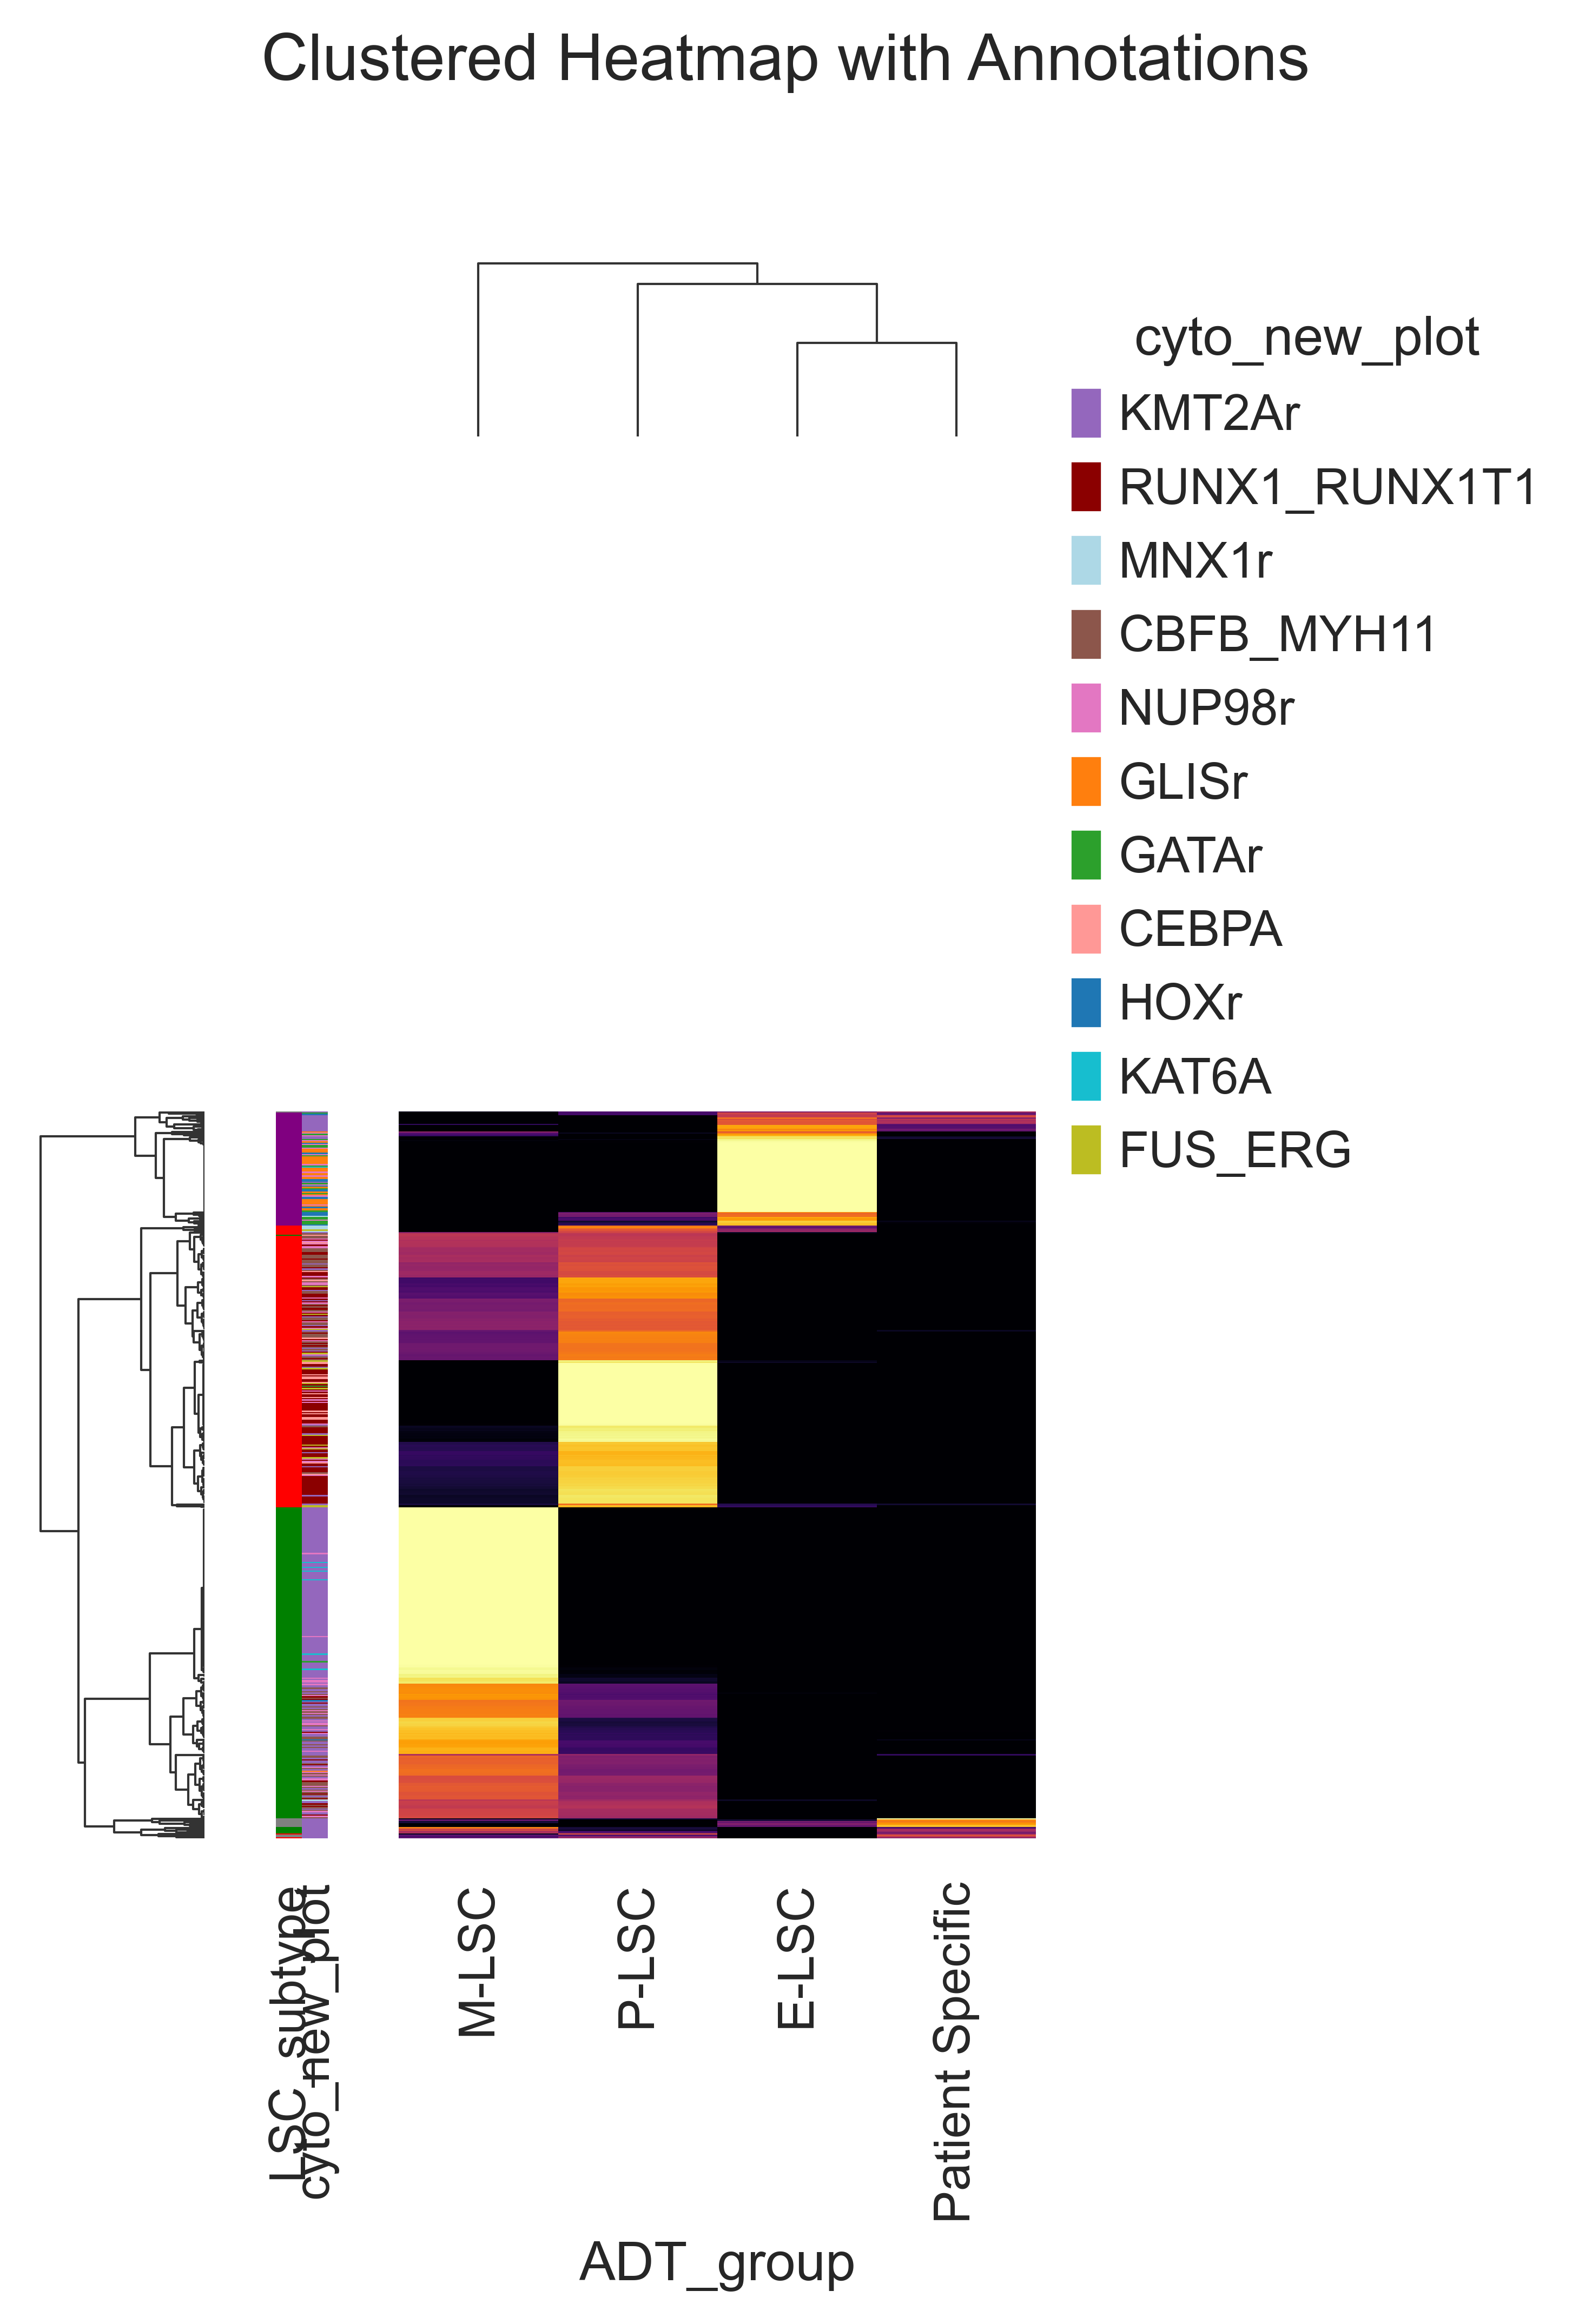

In [32]:
# Align meta_df to filtered df_props
filtered_df = df_props[~df_props["cyto_new_plot"].isin(["others"])]
meta_filtered = meta_df.loc[filtered_df.index]

# Check required columns
assert all(col in meta_filtered.columns for col in ["cyto_new_plot","LSC_subtype"]), "Missing columns in metadata!"

# Select numeric columns for heatmap
numeric_df = filtered_df.select_dtypes(include=[float, int])
# Remove rows or columns with all NaNs
numeric_df = numeric_df.dropna(axis=0, how="all").dropna(axis=1, how="all")

# Fill remaining NaNs with 0 (or another strategy)
numeric_df = numeric_df.fillna(0)

# Remove inf values if any
numeric_df = numeric_df.replace([np.inf, -np.inf], 0)


# Call the function
plot_clustered_heatmap_with_annotations(
    numeric_df,
    metadata_df=meta_filtered,
    group_cols=["LSC_subtype","cyto_new_plot"]
)


In [ ]:
plot_boxplot_with_stats_gene(adata[ (~adata.obs["LSC_subtype"].isin(["Patient Specific"]))], 
categorical_col = "LSC_subtype", gene_name = "CLEC12A", figsize = (6,3), palette = colors_LSC,save_path = "/CLEC12A_LSC_clus.pdf",
yline = np.mean(adata[:,"CLEC12A"].X),jitter=True,
 show_all_pairs = True)

In [ ]:
plot_boxplot_with_stats_gene(adata[ (~adata.obs["LSC_subtype"].isin(["Patient Specific"]))], 
categorical_col = "LSC_subtype", gene_name = "CD84", figsize = (6,3), palette = colors_LSC,save_path = "/CD84_LSC_clus.pdf",
yline = np.mean(adata[:,"CD84"].X),jitter=True,
 show_all_pairs = True)

In [37]:
adata.obs["cyto_LSC_type"] = adata.obs["cyto"].astype("str") + adata.obs["LSC_subtype"].astype("str")

label_high_low_gene_expression(adata, "CLEC12A")
label_high_low_gene_expression(adata, "CD84")
label_high_low_gene_expression(adata, "IL1RAP")
label_high_low_gene_expression(adata, "NCAM1")
label_high_low_gene_expression(adata, "CD4")
label_high_low_gene_expression(adata, "CD93")
label_high_low_gene_expression(adata, "CSF1R")
label_high_low_gene_expression(adata, "ADGRE2")

adata.obs["CLEC12_CD84"] = adata.obs["CLEC12A_high_low"].astype("str") + adata.obs["CD84_high_low"].astype("str")
adata.obs["CLEC12_IL1RAP"] = adata.obs["CLEC12A_high_low"].astype("str") + adata.obs["IL1RAP_high_low"].astype("str")

adata.obs["CLEC12_CD84_IL1RAP"] = adata.obs["CLEC12A_high_low"].astype("str") + adata.obs["CD84_high_low"].astype("str") + adata.obs["IL1RAP_high_low"].astype("str")
adata.obs["CD4_CD93"] = adata.obs["CD4_high_low"].astype("str") + adata.obs["CD93_high_low"].astype("str")

In [ ]:
# Filter and group
filtered_df = adata.obs

# Count values of CLEC12_CD84_IL1RAP (excluding 'others' in cyto_new)
counts = filtered_df["CLEC12_CD84_IL1RAP"][~filtered_df["cyto_new"].isin(["others"])].value_counts()

# Keep only counts > 2
counts = counts[counts > 2]

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,  # No labels on slices
    autopct='%1.1f%%',  # Show percentages
    startangle=90,
    textprops={'fontsize': 14, 'color': 'white'}  # White text inside
)

# Add legend instead of labels on slices
ax.legend(
    wedges,
    counts.index,  # Category names
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

# Remove y-label
plt.ylabel("")

# Save figure
plt.savefig("/Pie_all_threetargets.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Filter and group
filtered_df = adata.obs[adata.obs["CLEC12_CD84_IL1RAP"] == "CLEC12A_lowCD84_lowIL1RAP_low"]

# Count values of CLEC12_CD84_IL1RAP (excluding 'others' in cyto_new)
counts = filtered_df["cyto_LSC_type"][~filtered_df["cyto_new"].isin(["others"])].value_counts()

# Keep only counts > 2
counts = counts[counts > 2]

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,  # No labels on slices
    autopct='%1.1f%%',  # Show percentages
    startangle=90,
    textprops={'fontsize': 14, 'color': 'white'}  # White text inside
)

# Add legend instead of labels on slices
ax.legend(
    wedges,
    counts.index,  # Category names
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

# Remove y-label
plt.ylabel("")

# Save figure
plt.savefig("/Pie_all_threetargets_cyto.pdf", bbox_inches='tight')
plt.show()


In [40]:
# Extract columns
df = adata[(~adata.obs["LSC_subtype"].isin(["Patient Specific"])) & (~adata.obs["cyto_new"].isin(["others"]))].obs[["LSC_subtype", "CLEC12_CD84_IL1RAP"]]

# Prepare nodes
stages = ["LSC_subtype", "CLEC12_CD84_IL1RAP"]
nodes = pd.unique(df[stages].values.ravel())  # all unique labels
node_to_idx = {node: i for i, node in enumerate(nodes)}

# Define color mapping logic
def get_color(node):
    if isinstance(node, str) and node.startswith("CLEC12A_high"):
        return "#D2B48C"  # light brown
    elif isinstance(node, str) and "CD84_high" in node and "CLEC12A_low" in node:
        return "#ADD8E6"  # light blue
    elif node == "CLEC12A_lowCD84_lowIL1RAP_low":
        return "#B0B0B0"  # gray
    elif node == "CLEC12A_lowCD84_lowIL1RAP_high":
        return "orange"  # gray    
    else:
        return "#CCCCCC"  # default gray

# Assign colors to nodes
colors = [get_color(node) for node in nodes]

# Create links and color them based on target node
sources, targets, values, link_colors = [], [], [], []
for i in range(len(stages) - 1):
    group = df.groupby([stages[i], stages[i+1]]).size().reset_index(name="count")
    for _, row in group.iterrows():
        s_idx = node_to_idx[row[stages[i]]]
        t_idx = node_to_idx[row[stages[i+1]]]
        sources.append(s_idx)
        targets.append(t_idx)
        values.append(row["count"])
        link_colors.append(colors[t_idx])  # color from target node

# Build Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=10,
        line=dict(color="black", width=0.5),
        label=list(nodes),
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
))

# Update layout with custom size
fig.update_layout(
    title_text="Marker Status Flow by LSC Subtype",
    font_size=14,
    width=900,  # width in px
    height=600  # height in px
)

# Save figure (requires kaleido)
fig.write_image("/Sankey_LSC_CLEC12_CD84_IL1RAP.pdf")

fig.show()


2025-10-03 16:39:39 | [INFO] Chromium init'ed with kwargs {}
2025-10-03 16:39:39 | [INFO] Found chromium path: /Applications/Google Chrome.app/Contents/MacOS/Google Chrome
2025-10-03 16:39:39 | [INFO] Temp directory created: /var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/tmpif8vldvb.
2025-10-03 16:39:39 | [INFO] Opening browser.
2025-10-03 16:39:39 | [INFO] Temp directory created: /var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/tmp629xs598.
2025-10-03 16:39:39 | [INFO] Temporary directory at: /var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/tmp629xs598
2025-10-03 16:40:22 | [INFO] Conforming 1 to file:///var/folders/k9/hldft9d917ld0845xc2j18040000gp/T/tmpif8vldvb/index.html
2025-10-03 16:40:22 | [INFO] Waiting on all navigates
2025-10-03 16:40:30 | [INFO] All navigates done, putting them all in queue.
2025-10-03 16:40:30 | [INFO] Getting tab from queue (has 1)
2025-10-03 16:40:30 | [INFO] Got 122E
2025-10-03 16:40:30 | [INFO] Processing Marker_Status_Flow_by_LSC_Subtype.pdf
2025-10-

In [41]:
import re

# List of fusion/gene patterns and their short names
fusion_patterns = {
    r"HOX": "HOXr",
    r"GLIS": "GLISr",
    r"GATA": "GATAr",
    r"MNX1": "MNX1r",
    r"KMT2A": "KMT2Ar",
    r"MYH11": "CBFB_MYH11",
    r"RUNX1T1": "RUNX1_RUNX1T1",
    r"NUP98": "NUP98r",
    r"KAT6A": "KAT6A",
    r"FUS": "FUS_ERG",
    r"NPM1": "NPM1",
    r"MECOM": "MECOM",
    r"PICALM": "PICALM_MLLT10",
    r"PML::RARA": "PML_RARA",
     r"APL": "PML_RARA",
    r"UBTF": "UBTF",
    r"RBM15": "RBM15r",
    r"CEBPA": "CEBPA",
    r"DEK::NUP214": "DEK_NUP214",
    r"BCL11B": "BCL11B",
    r"PICALM::MLLT10": "PICALM_MLLT10",
    r"BCR::ABL1": "BCR_ABL1",
    r"KMT2A::PTD": "KMT2A_PTD"
}

def classify_with_lsc(row):
    cyto_text = str(row["cyto"])
    lsc = str(row["LSC_subtype"]) if pd.notna(row["LSC_subtype"]) else ""

    # Match fusion pattern
    for pattern, short_name in fusion_patterns.items():
        if re.search(pattern, cyto_text):
            # Attach LSC subtype if available
            if lsc in ["M-LSC enriched", "P-LSC enriched", "E-LSC enriched"]:
                return f"{short_name}_{lsc}"
            else:
                return short_name

    return "others"

# Apply classification
adata.obs["cyto_new"] = adata.obs.apply(classify_with_lsc, axis=1)


In [42]:
def classify_with_lsc(row):
    cyto_text = str(row["cyto"])
    lsc = str(row["LSC_subtype"]) if pd.notna(row["LSC_subtype"]) else ""

    # Match fusion pattern
    for pattern, short_name in fusion_patterns.items():
        if re.search(pattern, cyto_text):
            # Attach LSC subtype if available
            full_name = short_name
            if lsc in ["M-LSC enriched", "P-LSC enriched", "E-LSC enriched"]:
                full_name_lsc = f"{short_name}_{lsc}"
            else:
                full_name_lsc = short_name
            return pd.Series([full_name_lsc, full_name])  # return both
    return pd.Series(["others", "others"])

# Apply classification
adata.obs[["cyto_new_lsc", "cyto_new"]] = adata.obs.apply(classify_with_lsc, axis=1)


In [44]:
list(adata.obs["cyto_new_lsc"].value_counts()[adata.obs["cyto_new_lsc"].value_counts()> 3].index)

['others',
 'KMT2Ar_M-LSC enriched',
 'RUNX1_RUNX1T1_P-LSC enriched',
 'CBFB_MYH11_P-LSC enriched',
 'CBFB_MYH11_M-LSC enriched',
 'GLISr_E-LSC enriched',
 'NPM1_P-LSC enriched',
 'NUP98r_M-LSC enriched',
 'NUP98r_P-LSC enriched',
 'KMT2Ar_P-LSC enriched',
 'CEBPA_P-LSC enriched',
 'GATAr_E-LSC enriched',
 'KMT2Ar_E-LSC enriched',
 'HOXr_E-LSC enriched',
 'FUS_ERG_P-LSC enriched',
 'NPM1_M-LSC enriched',
 'NUP98r_E-LSC enriched',
 'RUNX1_RUNX1T1_M-LSC enriched',
 'UBTF_P-LSC enriched',
 'KMT2Ar',
 'DEK_NUP214_P-LSC enriched',
 'PICALM_MLLT10_P-LSC enriched',
 'KAT6A_M-LSC enriched',
 'MECOM_P-LSC enriched',
 'RBM15r_M-LSC enriched',
 'MECOM_M-LSC enriched',
 'MNX1r_P-LSC enriched',
 'RBM15r_E-LSC enriched']

In [45]:
groups_plot = ['KMT2Ar_M-LSC enriched',
 'RUNX1_RUNX1T1_P-LSC enriched',
 'CBFB_MYH11_P-LSC enriched',
 'CBFB_MYH11_M-LSC enriched',
 'GLISr_E-LSC enriched',
 'NPM1_P-LSC enriched',
 'KMT2Ar_P-LSC enriched',
 'NUP98r_M-LSC enriched',
 'NUP98r_P-LSC enriched',
 'CEBPA_P-LSC enriched',
 'NPM1_M-LSC enriched',
 'GATAr_E-LSC enriched',
 'HOXr_E-LSC enriched',
 'KMT2Ar_E-LSC enriched',
 "PICALM_MLLT10_P-LSC enriched",
 'FUS_ERG_P-LSC enriched',
 'NUP98r_E-LSC enriched',
 'DEK_NUP214_P-LSC enriched',
 "KAT6A_M-LSC enriched",
 'RUNX1_RUNX1T1_M-LSC enriched',
 'UBTF_P-LSC enriched',
 "MNX1r_P-LSC enriched",
 'RBM15r_M-LSC enriched',
 "RBM15r_E-LSC enriched","MECOM_P-LSC enriched" ,"MECOM_M-LSC enriched"]

In [46]:
groups_plot_sorted = [
    # E-LSC first
    'GLISr_E-LSC enriched',
    'GATAr_E-LSC enriched',
    'HOXr_E-LSC enriched',
    'KMT2Ar_E-LSC enriched',
    'NUP98r_E-LSC enriched',
    "RBM15r_E-LSC enriched",

    # M-LSC second
    'KMT2Ar_M-LSC enriched',
    'CBFB_MYH11_M-LSC enriched',
    'NUP98r_M-LSC enriched',
    'RUNX1_RUNX1T1_M-LSC enriched',
    'NPM1_M-LSC enriched',
    "KAT6A_M-LSC enriched",
    "MECOM_M-LSC enriched",
    "RBM15r_M-LSC enriched",

    # P-LSC last
    "MNX1r_P-LSC enriched",
    'RUNX1_RUNX1T1_P-LSC enriched',
    'CBFB_MYH11_P-LSC enriched',
    'NPM1_P-LSC enriched',
    'KMT2Ar_P-LSC enriched',
    'NUP98r_P-LSC enriched',
    'DEK_NUP214_P-LSC enriched',
    "PICALM_MLLT10_P-LSC enriched",
    "MECOM_P-LSC enriched",
    'CEBPA_P-LSC enriched',
    'FUS_ERG_P-LSC enriched',
    'UBTF_P-LSC enriched'
]


/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'cyto' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'sj_associated_diagnoses' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'sj_diseases' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'cyto_new_plot' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/ann

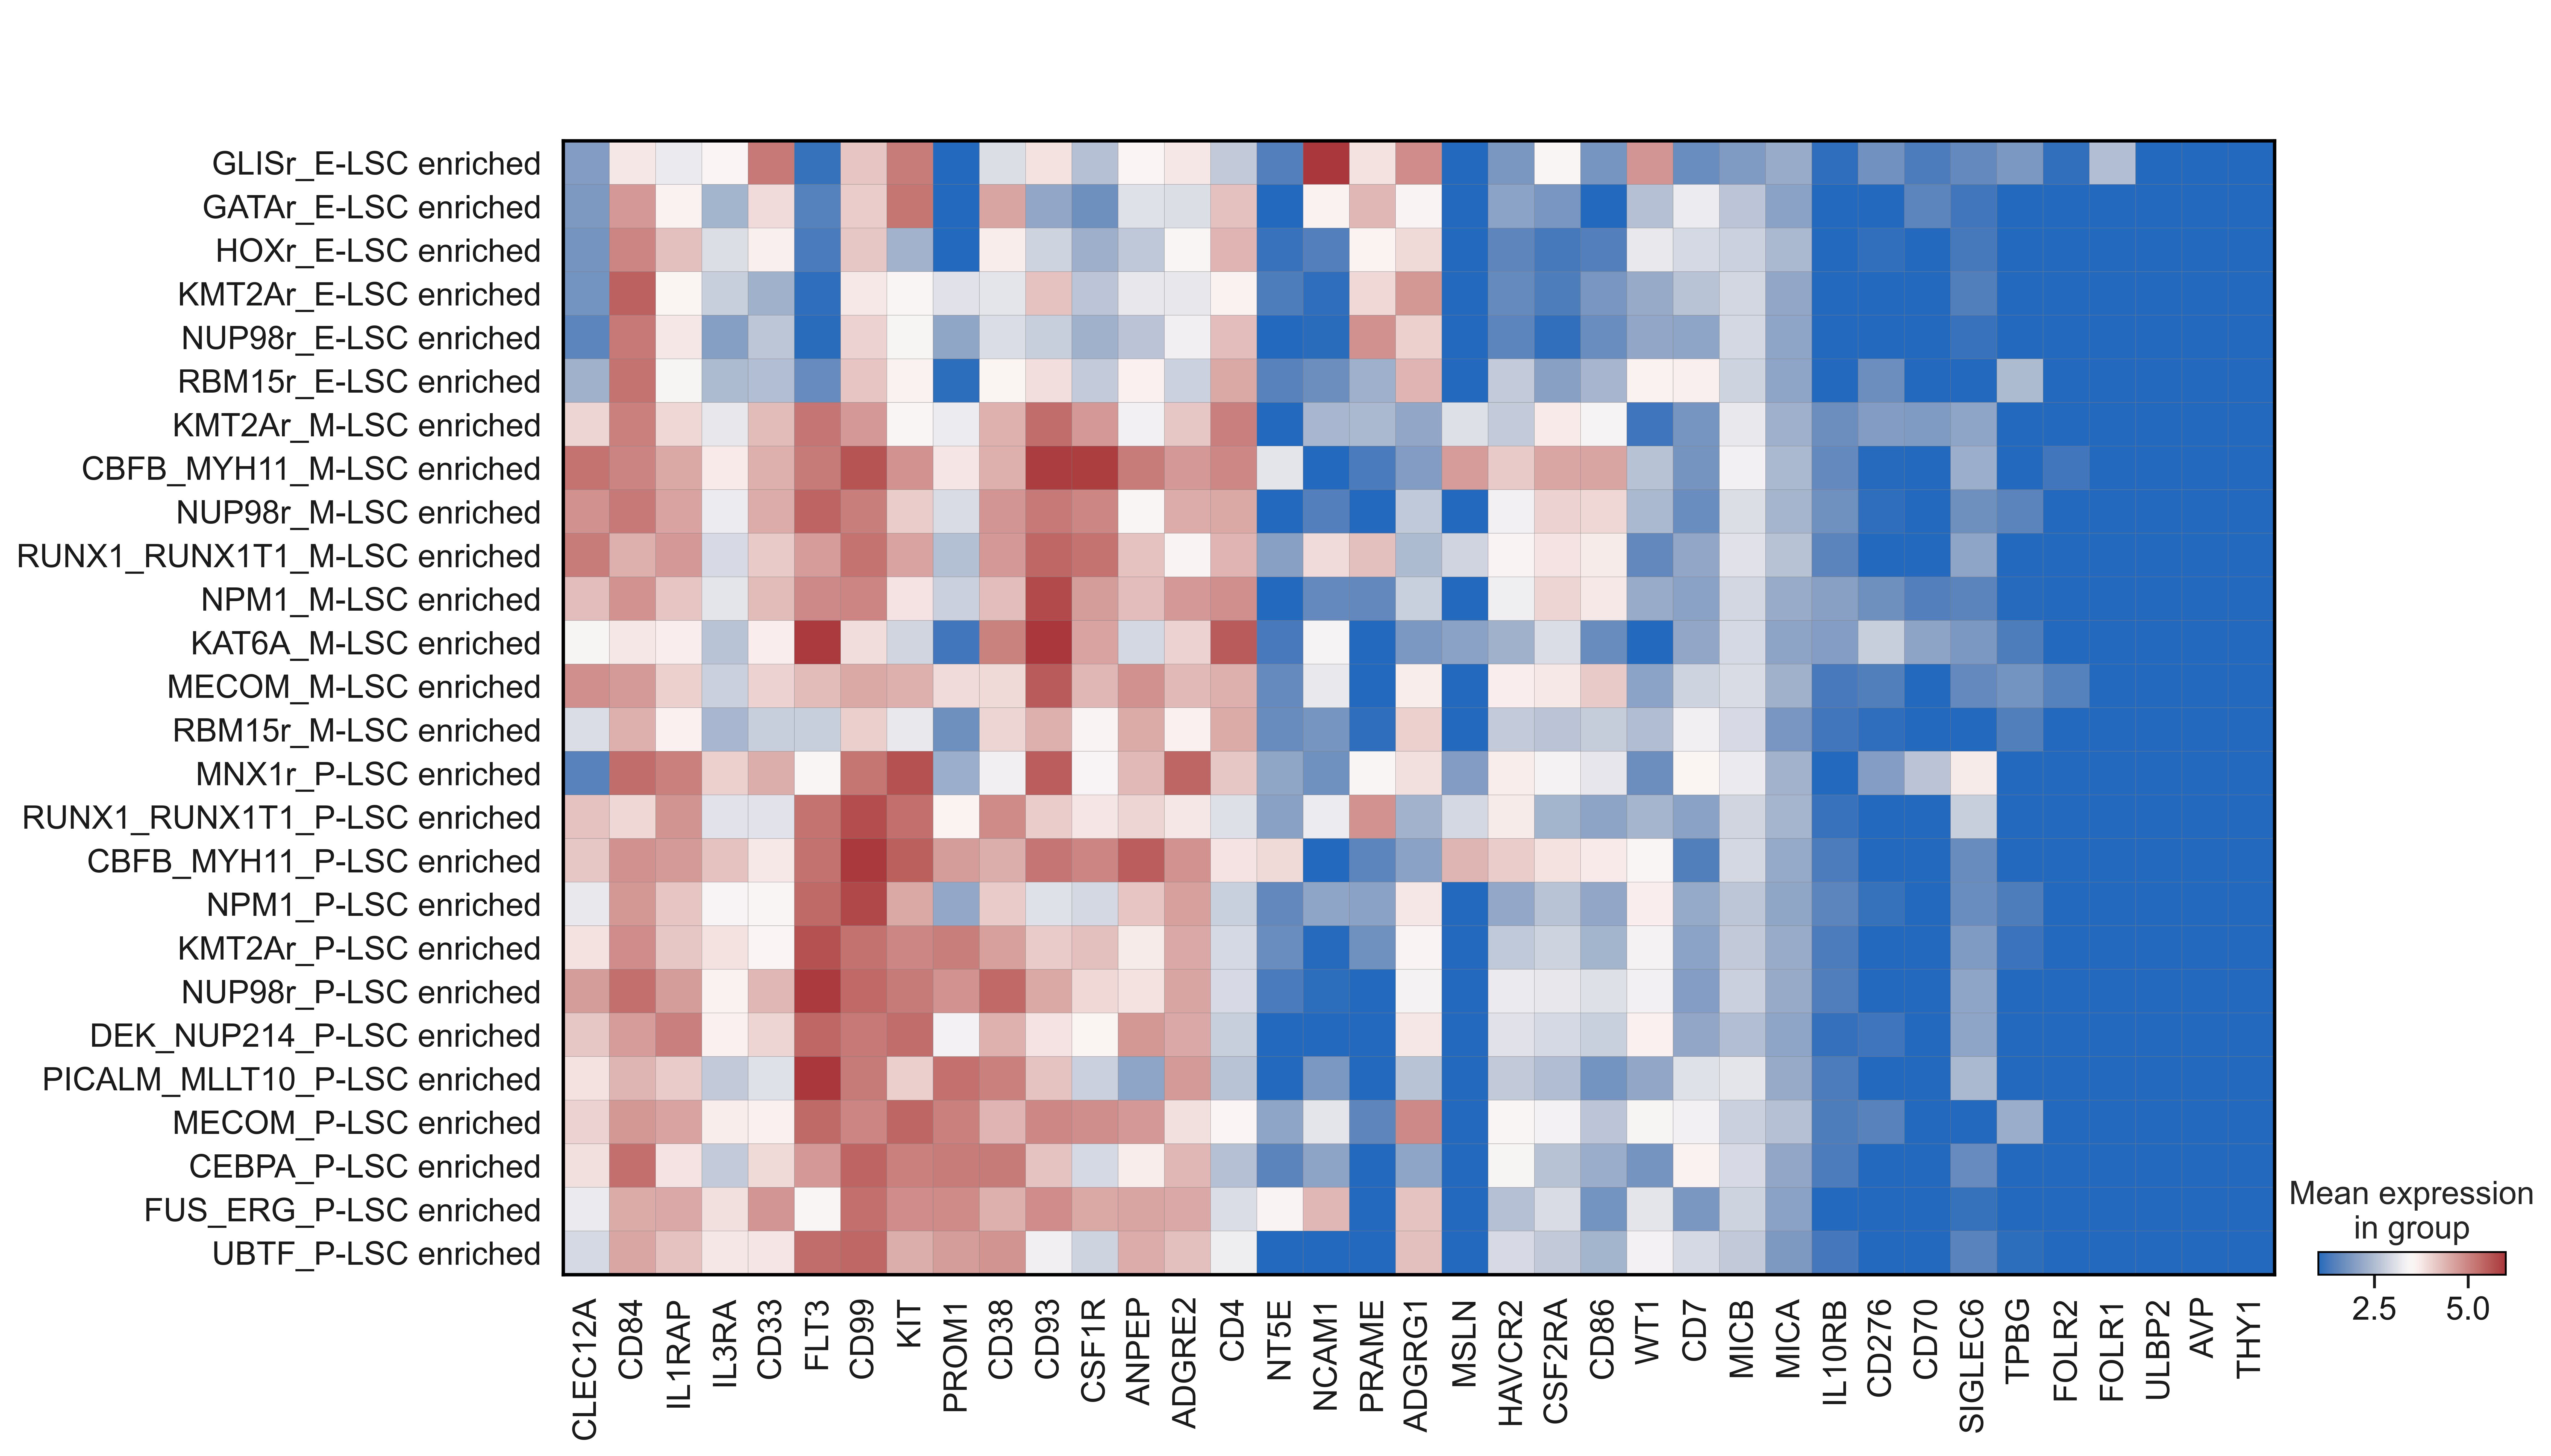

In [47]:
sc.settings.set_figure_params(
    dpi=300,
    facecolor="white",
    frameon=False, fontsize = 17
)

sc.pl.matrixplot(adata[adata.obs["cyto_new_lsc"].isin(groups_plot)], groupby = "cyto_new_lsc", var_names = ["CLEC12A","CD84","IL1RAP","IL3RA","CD33","FLT3","CD99","KIT","PROM1","CD38","CD93","CSF1R","ANPEP","ADGRE2","CD4","NT5E",
"NCAM1","PRAME","ADGRG1","MSLN", "HAVCR2","CSF2RA","CD86","WT1","CD7","MICB","MICA",
"IL10RB","CD276","CD70","SIGLEC6","TPBG","FOLR2","FOLR1","ULBP2","AVP", "THY1"],vmax = 6,vmin = 1,
 cmap = "vlag", swap_axes = False, categories_order = groups_plot_sorted, save = "targets_sj.pdf")


/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'cyto' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'sj_associated_diagnoses' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'sj_diseases' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

... storing 'cyto_new_plot' as categorical
/opt/anaconda3/envs/survival/lib/python3.10/site-packages/ann

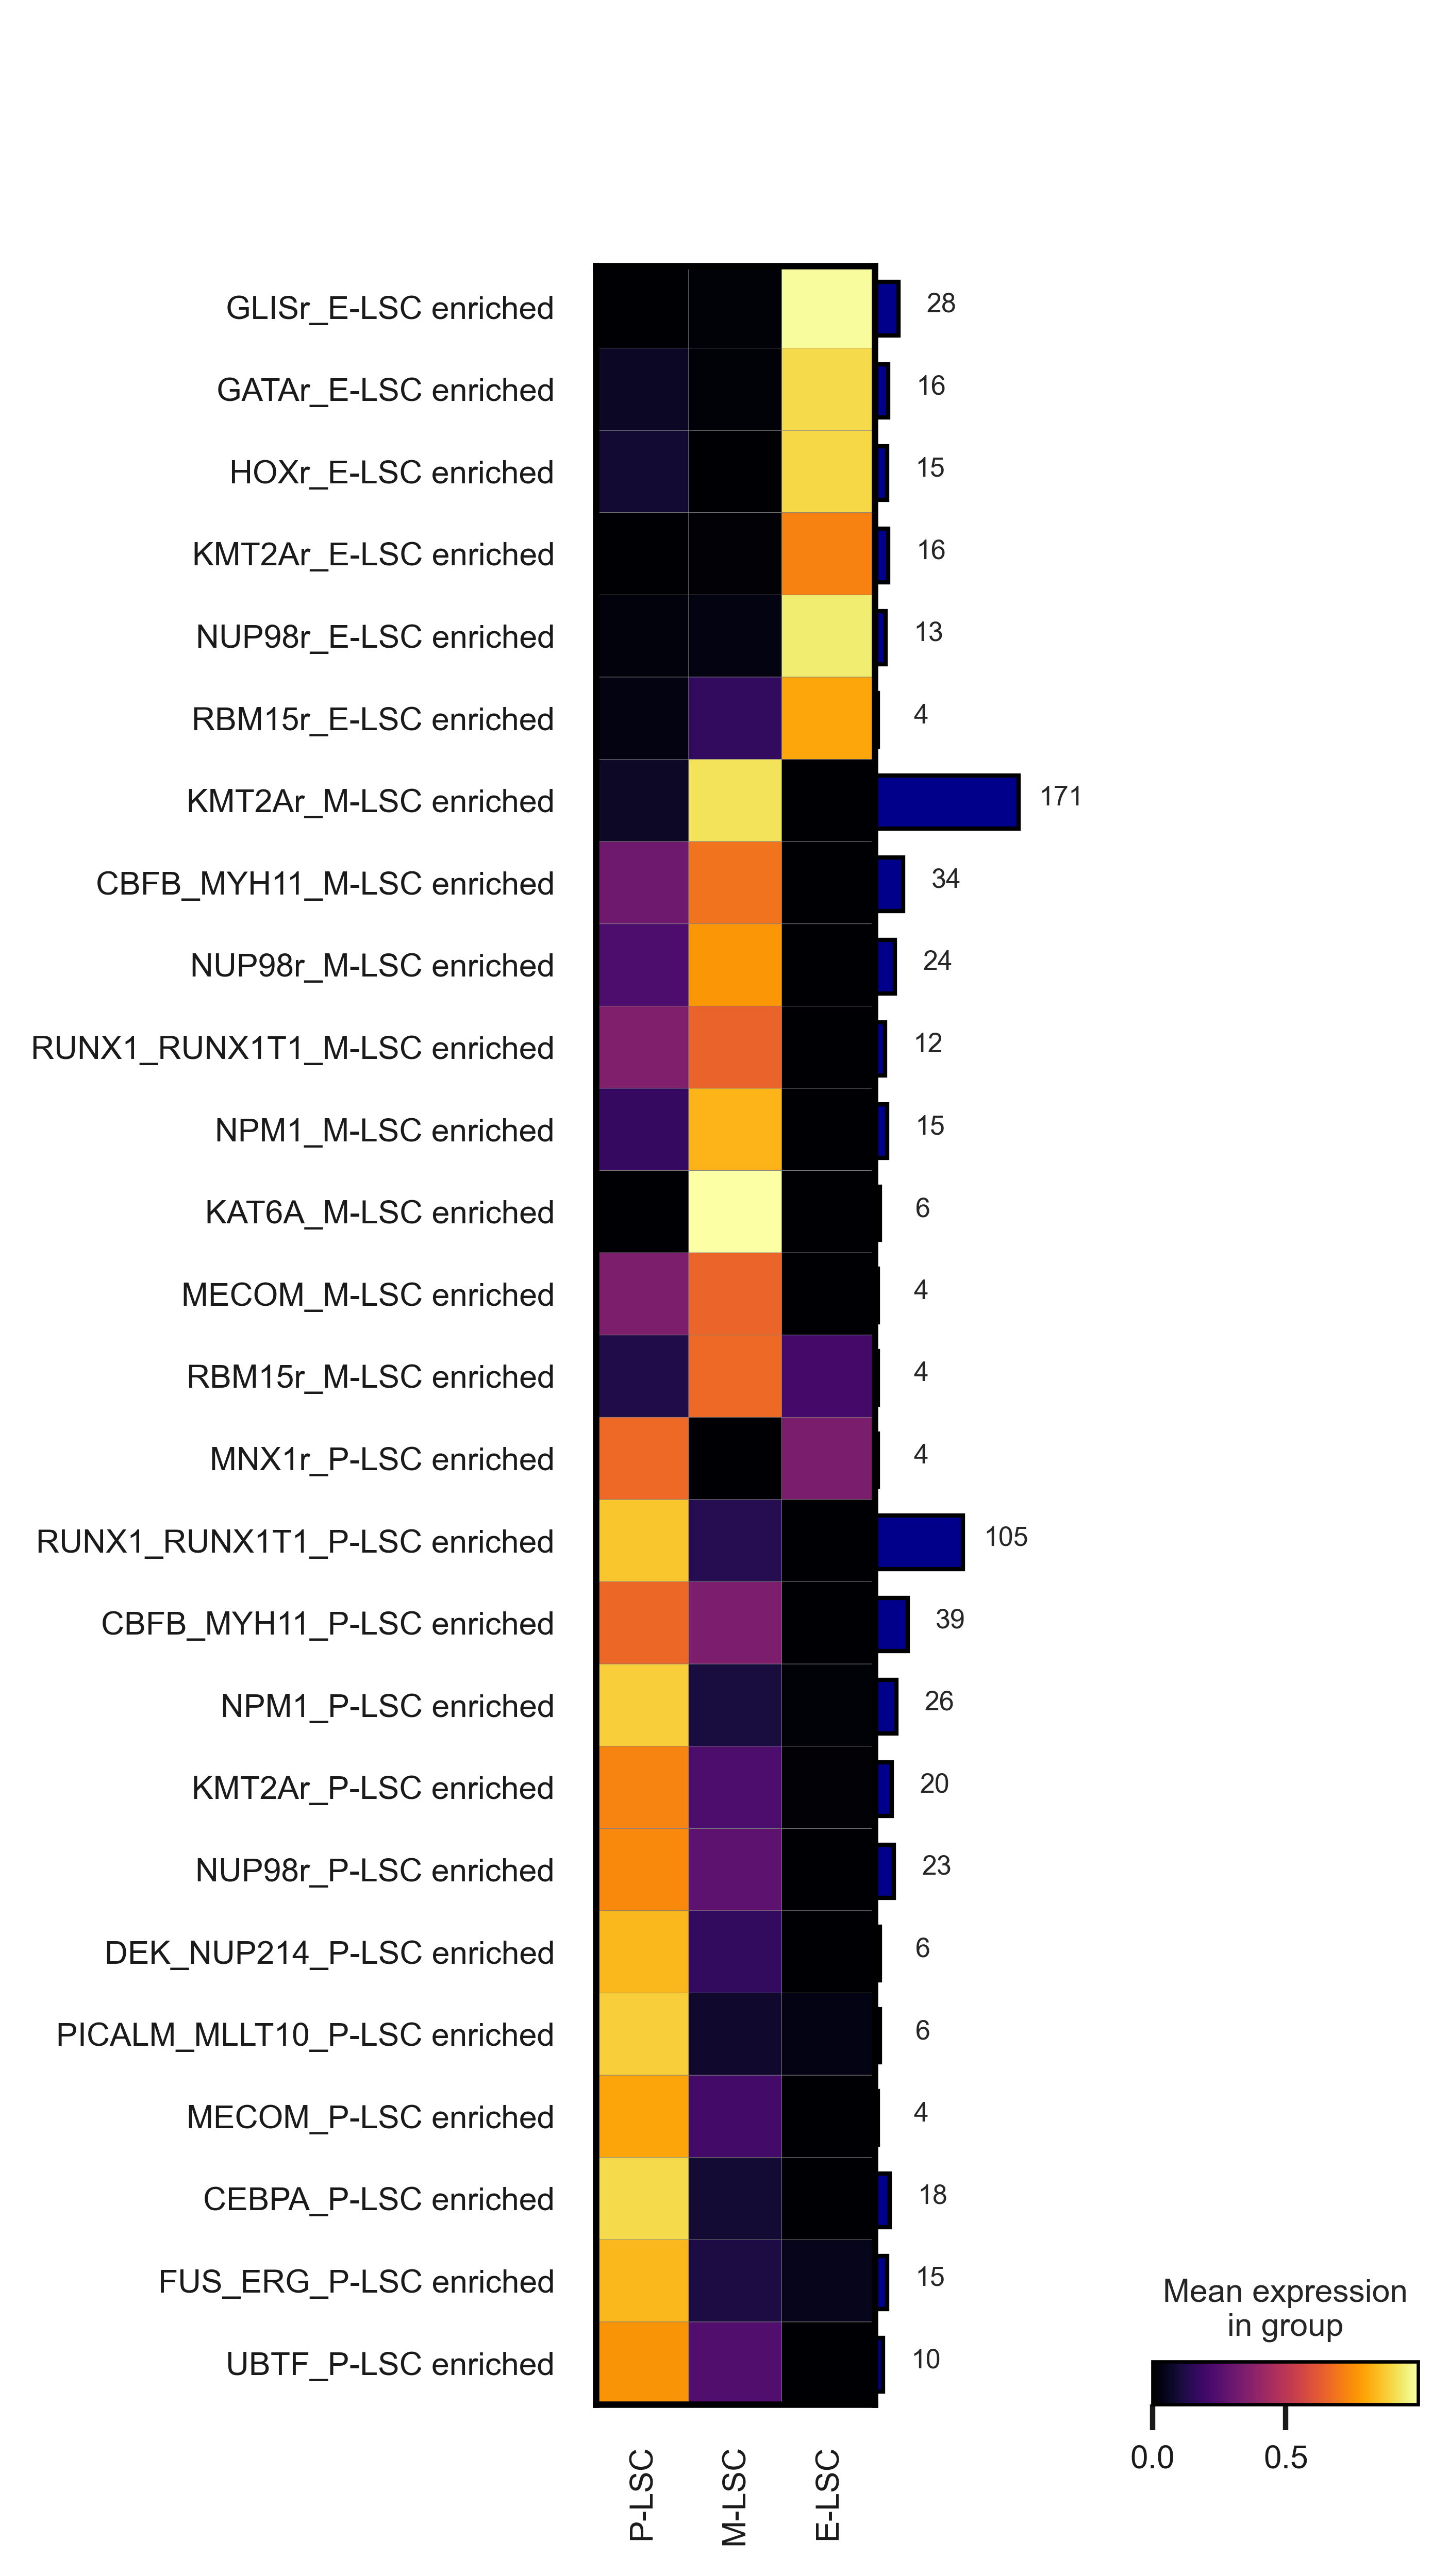

2025-10-03 16:45:40 | [INFO] maxp pruned
2025-10-03 16:45:40 | [INFO] LTSH dropped
2025-10-03 16:45:40 | [INFO] cmap pruned
2025-10-03 16:45:40 | [INFO] kern dropped
2025-10-03 16:45:40 | [INFO] post pruned
2025-10-03 16:45:40 | [INFO] PCLT dropped
2025-10-03 16:45:40 | [INFO] JSTF dropped
2025-10-03 16:45:40 | [INFO] DSIG dropped
2025-10-03 16:45:40 | [INFO] GPOS pruned
2025-10-03 16:45:40 | [INFO] GSUB pruned
2025-10-03 16:45:40 | [INFO] glyf pruned
2025-10-03 16:45:40 | [INFO] Added gid0 to subset
2025-10-03 16:45:40 | [INFO] Added first four glyphs to subset
2025-10-03 16:45:40 | [INFO] Closing glyph list over 'GSUB': 52 glyphs before
2025-10-03 16:45:40 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 'three', 'two', 'u',

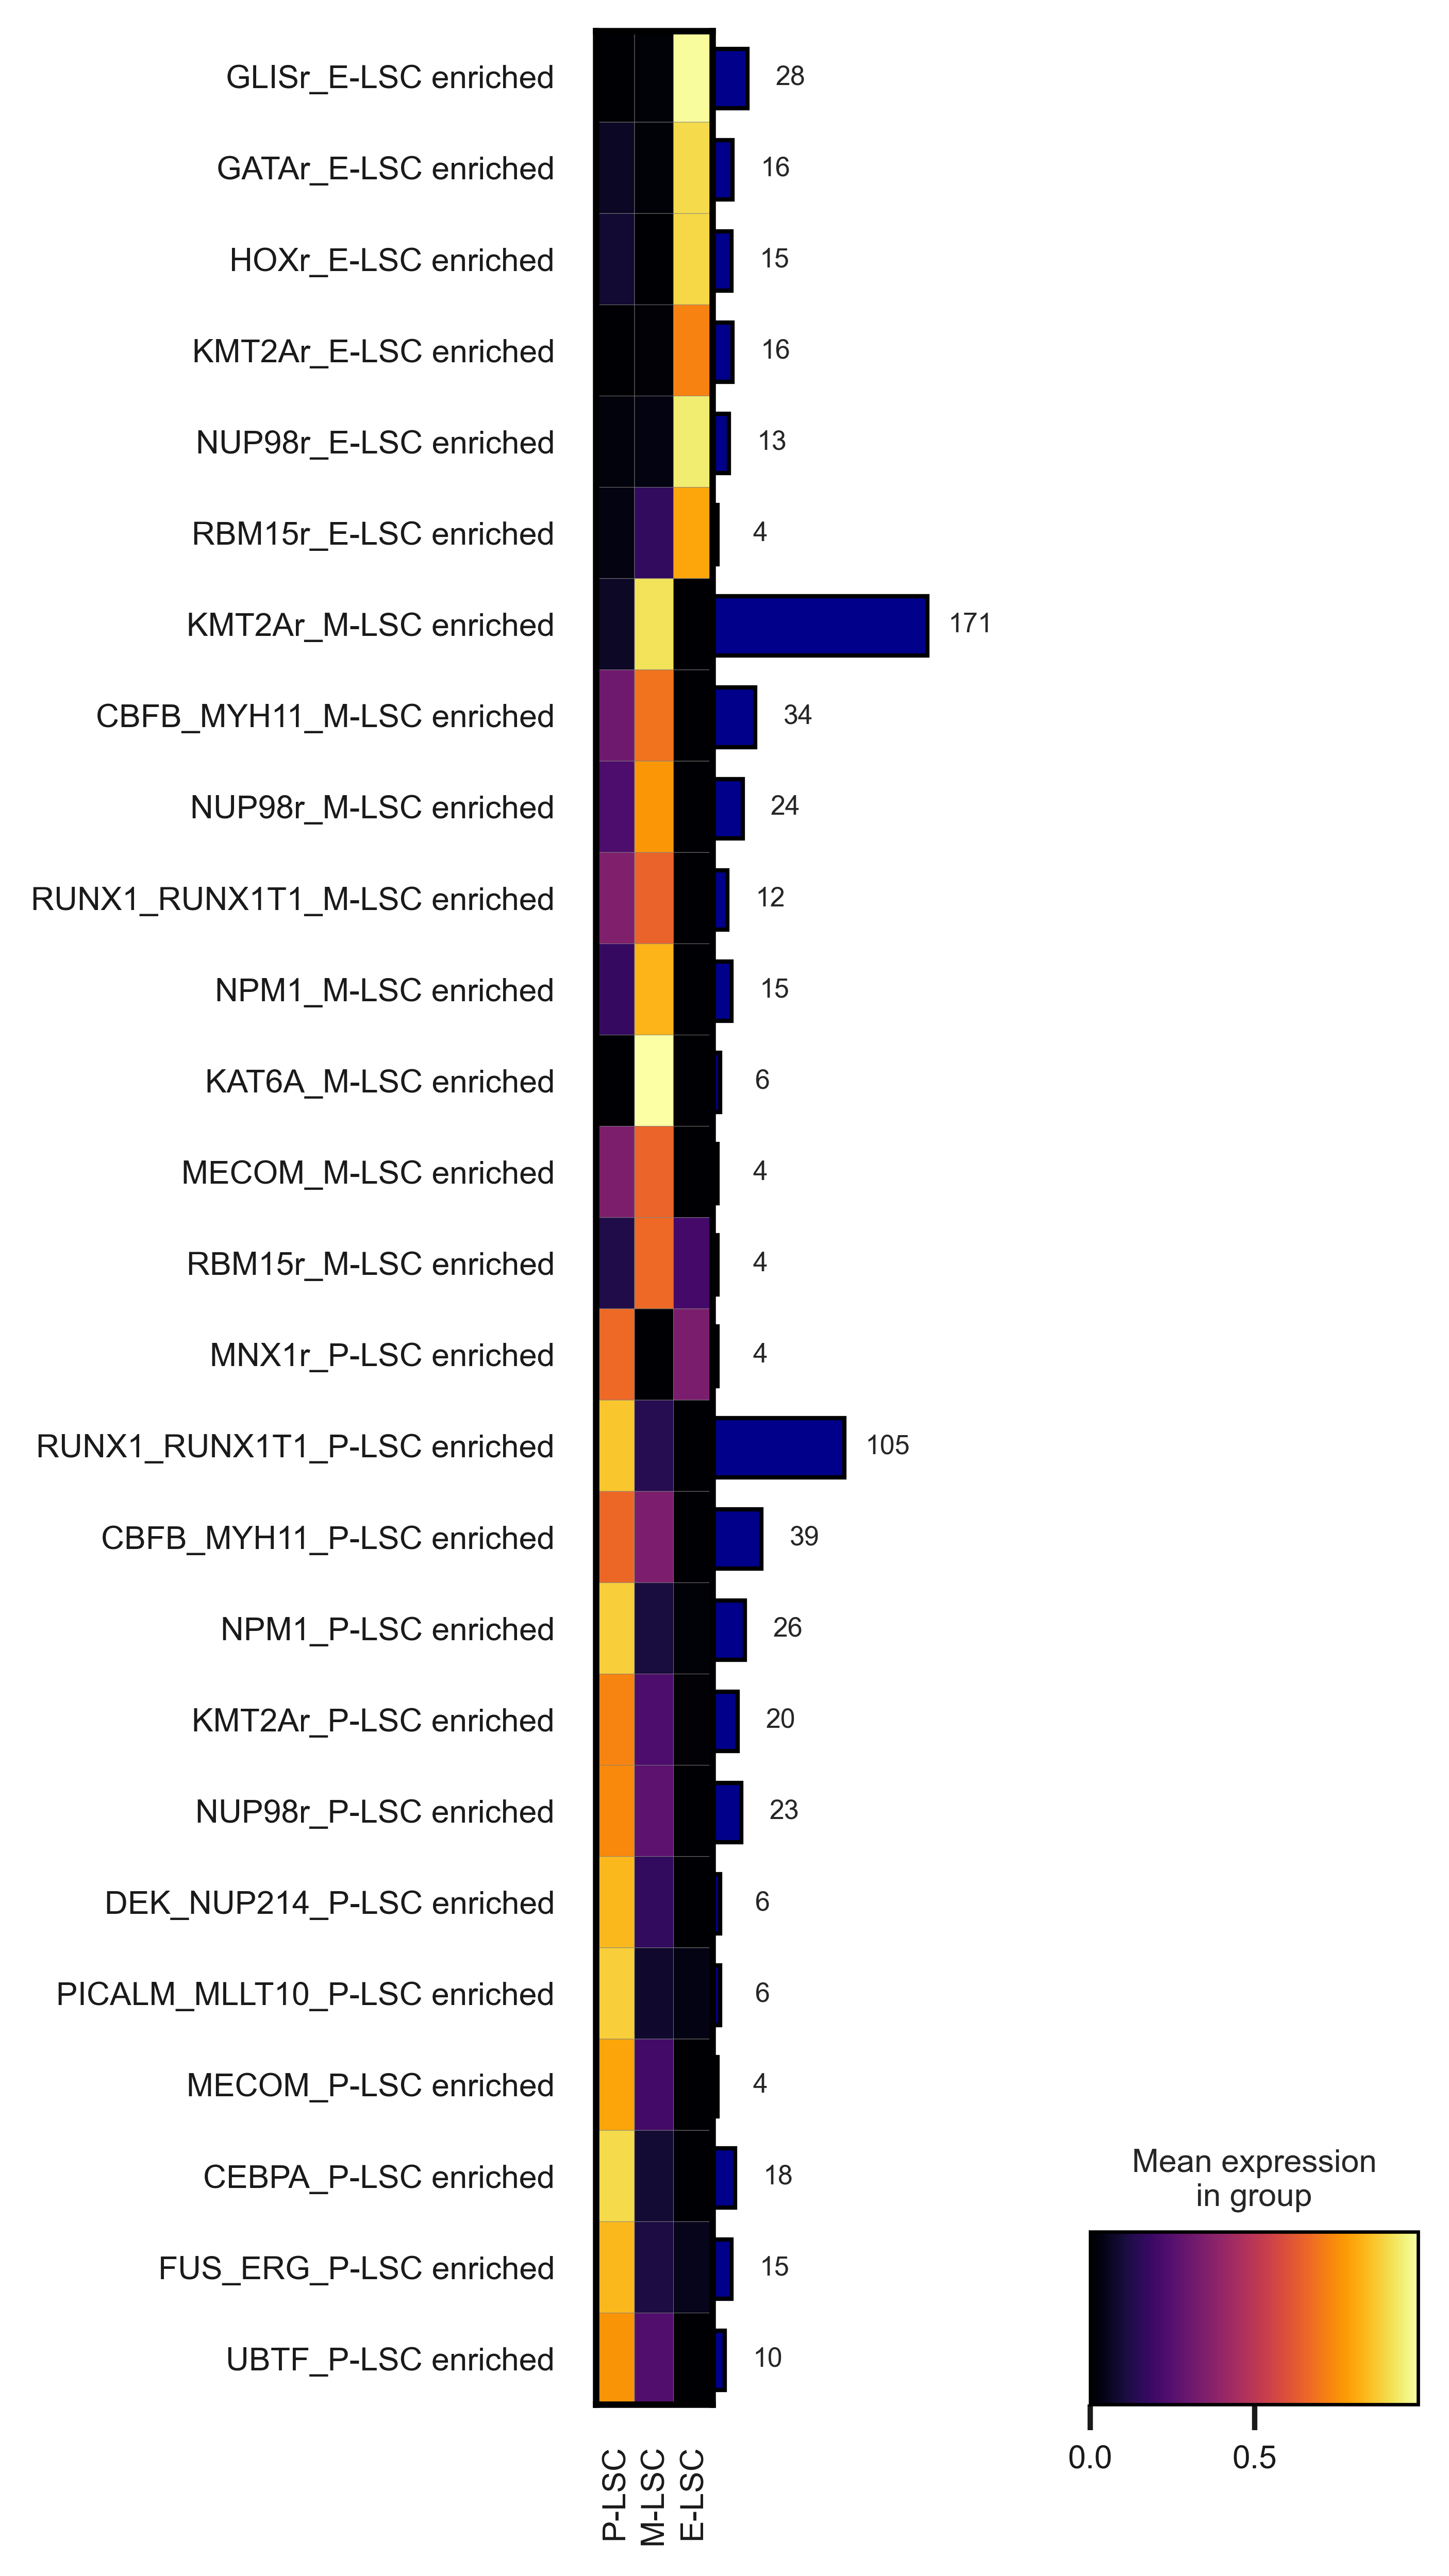

In [49]:
sc.settings.set_figure_params(
    dpi=300,
    facecolor="white",
    frameon=False, fontsize = 9
    
)

mp = sc.pl.matrixplot(adata[adata.obs["cyto_new_lsc"].isin(groups_plot)], groupby = "cyto_new_lsc", var_names = ["P-LSC","M-LSC","E-LSC"], cmap = "inferno", swap_axes = False,
    categories_order = groups_plot_sorted, return_fig=True)
mp.add_totals(color = "darkblue").show()
mp.savefig("/LSC_scores_sj.pdf")